In [5]:
#Reference: https://keras.io/examples/vision/captcha_ocr/

# Check GPU Machine

#!nvidia-smi

# Load Packages

import os
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Download Dataset

#!wget https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
#!unzip -q captcha_images_v2.zip



C:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:511: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

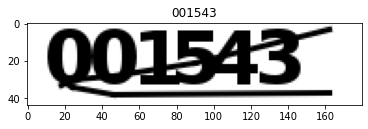

In [2]:
# Preview Dataset

img_list = glob('img/*.png')

len(img_list)

img = cv2.imread(img_list[0])

label = os.path.splitext(os.path.basename(img_list[0]))[0]

plt.title(label)
plt.imshow(img)

In [3]:
# Preprocessing

imgs = []
labels = []
max_length = 0

for img_path in img_list:
  imgs.append(img_path)

  label = os.path.splitext(os.path.basename(img_path))[0]
  labels.append(label)

  if len(label) > max_length:
    max_length = len(label)

print(len(imgs), len(labels), max_length)

''.join(labels)

characters = set(''.join(labels))
characters

193 193 31


{' ',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'T',
 'a',
 'c',
 'h',
 'p',
 't'}

In [4]:
# Encode Labels

char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=0, mask_token=None, invert=True
)

print(labels[0])
encoded = char_to_num(tf.strings.unicode_split(labels[0], input_encoding='UTF-8'))
print(encoded)

tf.strings.reduce_join(num_to_char(encoded)).numpy().decode('utf-8')

001543
tf.Tensor([12 12  9  3  8  5], shape=(6,), dtype=int64)


'001543'

In [5]:
# Split Dataset

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(imgs, labels, test_size=0.1, random_state=2021)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))



173 173
20 20


<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>
<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>


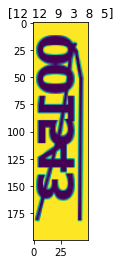

In [6]:
# Create Data Generator

img_width = 200
img_height = 50

def encode_single_sample(img_path, label):
  # 1. Read image
  img = tf.io.read_file(img_path)
  # 2. Decode and convert to grayscale
  img = tf.io.decode_png(img, channels=1)
  # 3. Convert to float32 in [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4. Resize to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  # 5. Transpose the image because we want the time
  # dimension to correspond to the width of the image.
  img = tf.transpose(img, perm=[1, 0, 2])
  # 6. Map the characters in label to numbers
  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  # 7. Return a dict as our model is expecting two inputs
  return {'image': img, 'label': label}

preview = encode_single_sample(imgs[0], labels[0])

plt.title(str(preview['label'].numpy()))
plt.imshow(preview['image'].numpy().squeeze())

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(validation_dataset)



In [7]:
# Model

# @title
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2'
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name='ctc_loss')(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name='ocr_model_v1'
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [1]:
# Train

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

NameError: name 'keras' is not defined

In [ ]:
# Test Inference

prediction_model = keras.models.Model(
  model.get_layer(name='image').input, model.get_layer(name='dense2').output
)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

for batch in validation_dataset.take(1):
    batch_images = batch['image']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(8, 4, figsize=(16, 12))

    for img, text, ax in zip(batch_images, pred_texts, axes.flatten()):
        img = img.numpy().squeeze()
        img = img.T

        ax.imshow(img, cmap='gray')
        ax.set_title(text)
        ax.set_axis_off()